In [20]:
!pip install git+https://github.com/ssut/py-hanspell.git
!pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/ssut/py-hanspell.git to /tmp/pip-req-build-mbr5deme
  Running command git clone -q https://github.com/ssut/py-hanspell.git /tmp/pip-req-build-mbr5deme
  Created wheel for py-hanspell: filename=py_hanspell-1.1-py3-none-any.whl size=4868 sha256=b59046d8d4dd0a46ec494ad65d7a283bf86fd1335418491583cd37f84f2899d1
  Stored in directory: /tmp/pip-ephem-wheel-cache-6xsx0od0/wheels/ab/f5/7b/d4124bb329c905301baed80e2ae45aa14e824f62ebc3ec2cc4
Successfully built py-hanspell
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [25]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import re

sonata = pd.read_csv('현대+쏘나타_label.csv') # 데이터 불러오기
sonata = sonata.drop(['likes'], axis = 1)
sonata.head(5)

,Unnamed: 0,comments,label
0,0,상위모델로 자연스럽게 유도하는 것 같습니다. 그랜저 ig부터는 둥글둥글하고 중후한 ...,0
1,1,확실히 깔끔하고 직관적인 리뷰,1
2,2,"현기가 클래스별 특징들이 점차 뚜렷해지는 모습입니다. 디자인도 좋아지고, 성능이 강...",0
3,3,루프부터 트렁크 끝단까지 라인 미쳤다 ㄷㄷ,0
4,4,옥스포드 블루칼라가 확실히 좋아 보입니다. 그레이 계열은 소나타의 젊음을 상쇄시키고...,0


In [22]:
from hanspell import spell_checker
from konlpy.tag import Okt
okt = Okt()

#이모티콘 제거 (아이폰 이모티콘들은 따로 코드가 존재)
emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00010000-\U0010FFFF"                   
                           "]+", flags=re.UNICODE)

#분석에 어긋나는 불용어구 제외 (특수문자, 의성어)
han = re.compile(r'[ㄱ-ㅎㅏ-ㅣ!?~,".\n\r#\ufeff\u200d\xa0]')

# train data(sonata)에 있는 댓글들 전처리를 위해 리스트화
comment_list = [] 
for i in range(len(sonata)):
    comment_list.append(sonata['comments'].iloc[i])
    
# 전처리 1 (댓글 이모지 밑 기호 정리 후 정규화)
comment_result = [] 

for i in comment_list:
    tokens = re.sub(emoji_pattern,"",i) # 이모지 패턴 적용
    tokens = re.sub(han,"",tokens) # han 적용
    tokens = re.sub('[-=+,#/\?:^.@*\"※%~∼ㆍ!【】』㈜©囹圄秋 ■◆◇▷▶◁◀ △▲▽▼<>‘|\(\)\[\]`\'…》→←↑↓↔〓♤♠♡♥♧♣⊙◈▣◐◑☆★\”\“\’·※~ ! @ # $ % ^ & * \ " ]', ' ', tokens)
    # 기타 특수문자들 제거
    tokens = okt.normalize(tokens) # 정규화
    comment_result.append(tokens)

comment_result

# 전처리 2 (spell_checker 활용하여 오탈자 수정)
checked_list = [] 
for comment in tqdm(comment_result):
    sent = comment
    try:
        spelled_sent = spell_checker.check(sent)
        checked_sent = spelled_sent.checked
        checked_list.append(checked_sent)
    except:
        print(sent)
        checked_list.append(sent)

# 학습을 위해 댓글과 라벨 컬럼만 있는 새로운 샘플 데이터프레임 생성
sample = pd.DataFrame() 
sample['comments'] = checked_list
sample['label'] = sonata['label']

 71%|███████   | 2142/3037 [07:51<05:05,  2.93it/s]

이게 리뷰지


100%|██████████| 3037/3037 [11:13<00:00,  4.51it/s]


In [41]:
sample

,comments,label
0,상위 모델로 자연스럽게 유도하는 것 같습니다 그랜저 ig부터는 둥글둥글하고 중후한 ...,0
1,확실히 깔끔하고 직관적인 리뷰,1
2,현기가 클래스별 특징들이 점차 뚜렷해지는 모습입니다 디자인도 좋아지고 성능이 강조된...,0
3,루프부터 트렁크 끝단까지 라인 미쳤다,0
4,옥스퍼드 블루칼라가 확실히 좋아 보입니다 그레이 계열은 소나타의 젊음을 상쇄시키고 ...,0
...,...,...
3032,언제 적 6단이냐 요새 보통 7단 8단 거의 기본 적용인데 6단이라니 ZF 미션 좀...,0
3033,잘 나 봤자 소나타여 그랜저 밑이지,0
3034,네비나 저기 각도가 저기 뭐니 균형 좀,0
3035,코너 돌 때 일부러 핸들을 흔드세요 코너 돌릴 때 행들 질이 좀 우습네요 가만히 꺾...,1


In [44]:
X_train, X_test,y_train, y_test = train_test_split(sample['comments'],sample['label'], test_size = 0.2, random_state = 32)
print('훈련용 리뷰의 개수 :', len(X_train))
print('테스트용 리뷰의 개수 :', len(X_test))

훈련용 리뷰의 개수 : 2429
테스트용 리뷰의 개수 : 608


In [45]:
X_train

1437                                         빰 효과음 좀 튀는 듯
1155                                    모터 그래프보다 조회 수 높네 
889     민노총 종북 노조가 만드는 이런 쓰레기차에 장점은 뭐고 아쉬운 점은 뭐냐 출시하자마...
2453              10 00 잘생긴 남성 목소리는 왜 없죠 몰라요  너무 잘라 말씀하신다
1530                                                입수 보행
                              ...                        
2136                                       깜디 형으로 바꾸면 안대나
2940                                            해외 판매에 치중
1334               와 외관 디자인 호불호 다 떠나서 내장 디자인 하나만큼은 진짜 죽인다
1579                  저 노란색을 뽑을 용기 있는 사람이 몇 명이나 있을지 궁금하다 
2775         엔진 공회전 소음은 주행을 살짝만 해도 줄어드는 느낌적인 느낌온도 때문에 그런가
Name: comments, Length: 2429, dtype: object

In [46]:
X_test

1728                                           4 50 입수 보행
1821                                 금색은 마티즈가 첫 번째 아닐까요  
2729    항상 잘 보고 있습니다 그런데 개인적으로는 LF나 뉴 라이즈의 고속주행 안정감은 다...
1865                            말이 쏘 나 타지  저 옵션이면 가격이 얼마야
1422                          굉장히 괴상하다 한 표 이따위로 만들고 잠이 올까
                              ...                        
2170                  벌써 이차가 2년 됐구나 다 좋은데 와꾸가 진짜 적응이 안 된다
1499    어디 모 기자님이 김한용 사장님 앉은키가 커서 뒷자리 머리 닿을 거 같다고 하셨는데...
2317                                             잘 보고 갑니다
1218                  실물 봤는데 엄청 납작하던데 키 큰 사람들은 누워서 타야 할 듯
493                                        형님 안 자고 기다렸습니다
Name: comments, Length: 608, dtype: object

In [54]:
import urllib.request
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# trian data 토큰화
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_encoded = tokenizer.texts_to_sequences(X_train)
print(X_train_encoded[:5])


# w2index
word_to_index = tokenizer.word_index
print(word_to_index[:5])

[[3244, 931, 5, 1252, 16], [216, 3245, 1253, 33, 3246], [3247, 3248, 1826, 621, 86, 3249, 1827, 3250, 217, 1254, 336, 1255, 28, 309, 115, 3251, 88, 3252, 1828, 310, 3253, 69, 1, 1829, 1, 1830, 197, 513, 932, 1831, 1832, 1833, 3254, 65, 752, 86, 1834, 622, 3255], [1256, 337, 3256, 3257, 1257, 21, 933, 1835, 4, 3258, 3259], [124, 169]]
{'잘': 1, '안': 2, '거': 3, '너무': 4, '좀': 5, '디자인': 6, '진짜': 7, '더': 8, '소나타': 9, '리뷰': 10, '것': 11, '차': 12, '게': 13, '보고': 14, '쏘나타': 15, '듯': 16, '정말': 17, '때': 18, '많이': 19, '뉴': 20, '왜': 21, '기자님': 22, '좋은': 23, '다': 24, '이': 25, '건': 26, '영상': 27, '엔진': 28, '디자인이': 29, '그냥': 30, '이번': 31, '역시': 32, '수': 33, '김한용': 34, '보면': 35, '와': 36, '그랜저': 37, '같은': 38, '근데': 39, '봤습니다': 40, '하는': 41, '현대': 42, '그': 43, '트렁크': 44, '다른': 45, '디자인은': 46, '저': 47, '같네요': 48, '시승기': 49, '있습니다': 50, '한상기': 51, '항상': 52, '중': 53, '라이즈': 54, '같아요': 55, '아': 56, '있는': 57, '참': 58, '감사합니다': 59, '요즘': 60, '한': 61, '아반떼': 62, '느낌이': 63, '때문에': 64, '차가': 65, '같은데': 66, '하고': 67

In [55]:
vocab_size = len(word_to_index) + 1
print('단어 집합의 크기: {}'.format((vocab_size)))

단어 집합의 크기: 11501


In [56]:
# 댓글 최대 길이에 따라 훈련 데이터 크기 설정 
long = max(len(sample) for sample in X_train_encoded) # 전처리 과정에서 댓글 최대 길이가 가끔 달라지기 때문에 long 변수 설정함
max_len = long
X_train_padded = pad_sequences(X_train_encoded, maxlen = max_len)

print("훈련 데이터의 크기(shape):", X_train_padded.shape)

# long = 137
# 훈련 데이터 크기 : (2429, 137)

훈련 데이터의 크기(shape): (2429, 137)


In [138]:
# 모델링

from tensorflow.keras.layers import Dense, Conv1D, GlobalMaxPooling1D, Embedding, Dropout, MaxPooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 32
dropout_ratio = 0.3
num_filters = 32
kernel_size = 4

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(Dropout(dropout_ratio))
model.add(Conv1D(num_filters, kernel_size, padding='valid', activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(dropout_ratio)) # 과적합 방지를 위해 validation loss가 3번 증가할 때 자동으로 학습 중지
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint('best_model.h5', monitor = 'val_acc', mode='max', verbose=1, save_best_only=True)

history = model.fit(X_train_padded, y_train, epochs=5, batch_size=137, validation_split=0.2, callbacks=[es, mc])

Epoch 1/5
14/15 [===========================>..] - ETA: 0s - loss: 0.6910 - acc: 0.5276
Epoch 1: val_acc improved from -inf to 0.56790, saving model to best_model.h5
15/15 [==============================] - 3s 81ms/step - loss: 0.6910 - acc: 0.5280 - val_loss: 0.6886 - val_acc: 0.5679
Epoch 2/5
15/15 [==============================] - ETA: 0s - loss: 0.6809 - acc: 0.6233
Epoch 2: val_acc improved from 0.56790 to 0.58436, saving model to best_model.h5
15/15 [==============================] - 1s 43ms/step - loss: 0.6809 - acc: 0.6233 - val_loss: 0.6858 - val_acc: 0.5844
Epoch 3/5
15/15 [==============================] - ETA: 0s - loss: 0.6684 - acc: 0.6835
Epoch 3: val_acc improved from 0.58436 to 0.61317, saving model to best_model.h5
15/15 [==============================] - 1s 43ms/step - loss: 0.6684 - acc: 0.6835 - val_loss: 0.6799 - val_acc: 0.6132
Epoch 4/5
15/15 [==============================] - ETA: 0s - loss: 0.6513 - acc: 0.7411
Epoch 4: val_acc improved from 0.61317 to 0.6275

In [139]:
X_test_encoded = tokenizer.texts_to_sequences(X_test)
X_test_padded = pad_sequences(X_test_encoded, maxlen = max_len)
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test_padded, y_test)[1]))

19/19 [==============================] - 0s 4ms/step - loss: 0.6538 - acc: 0.6530

 테스트 정확도: 0.6530


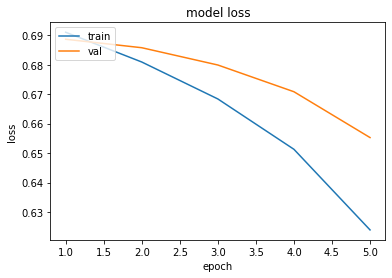

In [140]:
# loss 시각화(train loss, validation loss)

epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()